In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy.linalg import expm
from scipy.stats import spearmanr
import networkx as nx
from collections import defaultdict
import warnings
from typing import Dict, List, Set, Tuple
from math import comb
warnings.filterwarnings('ignore')

In [2]:
# global settings
# Set up plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

# Dataset directory
dataset_dir = 'dataset'

# GLOBAL CONFIGURATION: Set to True for weighted analysis, False for unweighted
is_weighted = False
file_prefix = 'weighted' if is_weighted else 'unweighted'

In [3]:
print("Power Grid Network Analysis")
print("=" * 50)

# Load all networks and basic statistics
networks = {}
network_stats = []

print("Loading networks...")
for i in range(1, 59):
    try:
        data = loadmat(os.path.join(dataset_dir, f'{i}.mat'))
        adj_matrix = data['A']
        adj_np = adj_matrix.toarray()
        assert (adj_np == adj_np.T).all(), "Adjacency matrix is not symmetric"
        assert np.diag(adj_np).sum() == 0, "Adjacency matrix has self-loops"
        
        # Convert sparse matrix to NetworkX graph
        if is_weighted and 'W' in data:
            # Use distance matrix as weights
            weight_matrix = data['W']
            G = nx.from_scipy_sparse_array(weight_matrix)
            print(f"Network {i}: Using weighted graph with distance matrix")
        else:
            # Use unweighted adjacency matrix
            G = nx.from_scipy_sparse_array(adj_matrix)
            if is_weighted:
                print(f"Network {i}: Warning - 'W' matrix not found, using unweighted")
        
        # Remove self-loops and ensure undirected
        G.remove_edges_from(nx.selfloop_edges(G))
        G = G.to_undirected()
        
        networks[i] = G
        
        # Collect basic statistics
        stats = {
            'network_id': i,
            'nodes': G.number_of_nodes(),
            'edges': G.number_of_edges(),
            'density': nx.density(G),
            'is_connected': nx.is_connected(G)
        }
        network_stats.append(stats)
        
        if i % 10 == 0:
            print(f"Loaded network {i}")
            
    except Exception as e:
        print(f"Error loading network {i}: {e}")

print(f"\nSuccessfully loaded {len(networks)} networks")

Power Grid Network Analysis
Loading networks...
Loaded network 10
Loaded network 20
Loaded network 30
Loaded network 40
Loaded network 50

Successfully loaded 58 networks



QUESTION 1: Redundancy Ratio Analysis

Processing Network 1...
  Computing RR for 47 nodes...
    Progress: 0/47 nodes
  Average RR: 0.161292
  Std Dev: 0.051776
  Range: [0.062500, 0.250000]

Processing Network 2...
  Computing RR for 50 nodes...
    Progress: 0/50 nodes
  Average RR: 0.200847
  Std Dev: 0.080565
  Range: [0.089965, 0.500000]

Processing Network 3...
  Computing RR for 52 nodes...
    Progress: 0/52 nodes
  Average RR: 0.159725
  Std Dev: 0.051111
  Range: [0.082645, 0.250000]

Processing Network 4...
  Computing RR for 57 nodes...
    Progress: 0/57 nodes
  Average RR: 0.170618
  Std Dev: 0.054619
  Range: [0.069252, 0.250000]

Processing Network 5...
  Computing RR for 61 nodes...
    Progress: 0/61 nodes
  Average RR: 0.167169
  Std Dev: 0.074046
  Range: [0.062500, 0.400000]

Processing Network 6...
  Computing RR for 62 nodes...
    Progress: 0/62 nodes
  Average RR: 0.173700
  Std Dev: 0.051460
  Range: [0.078125, 0.361111]

Processing Network 7...
  Computing 

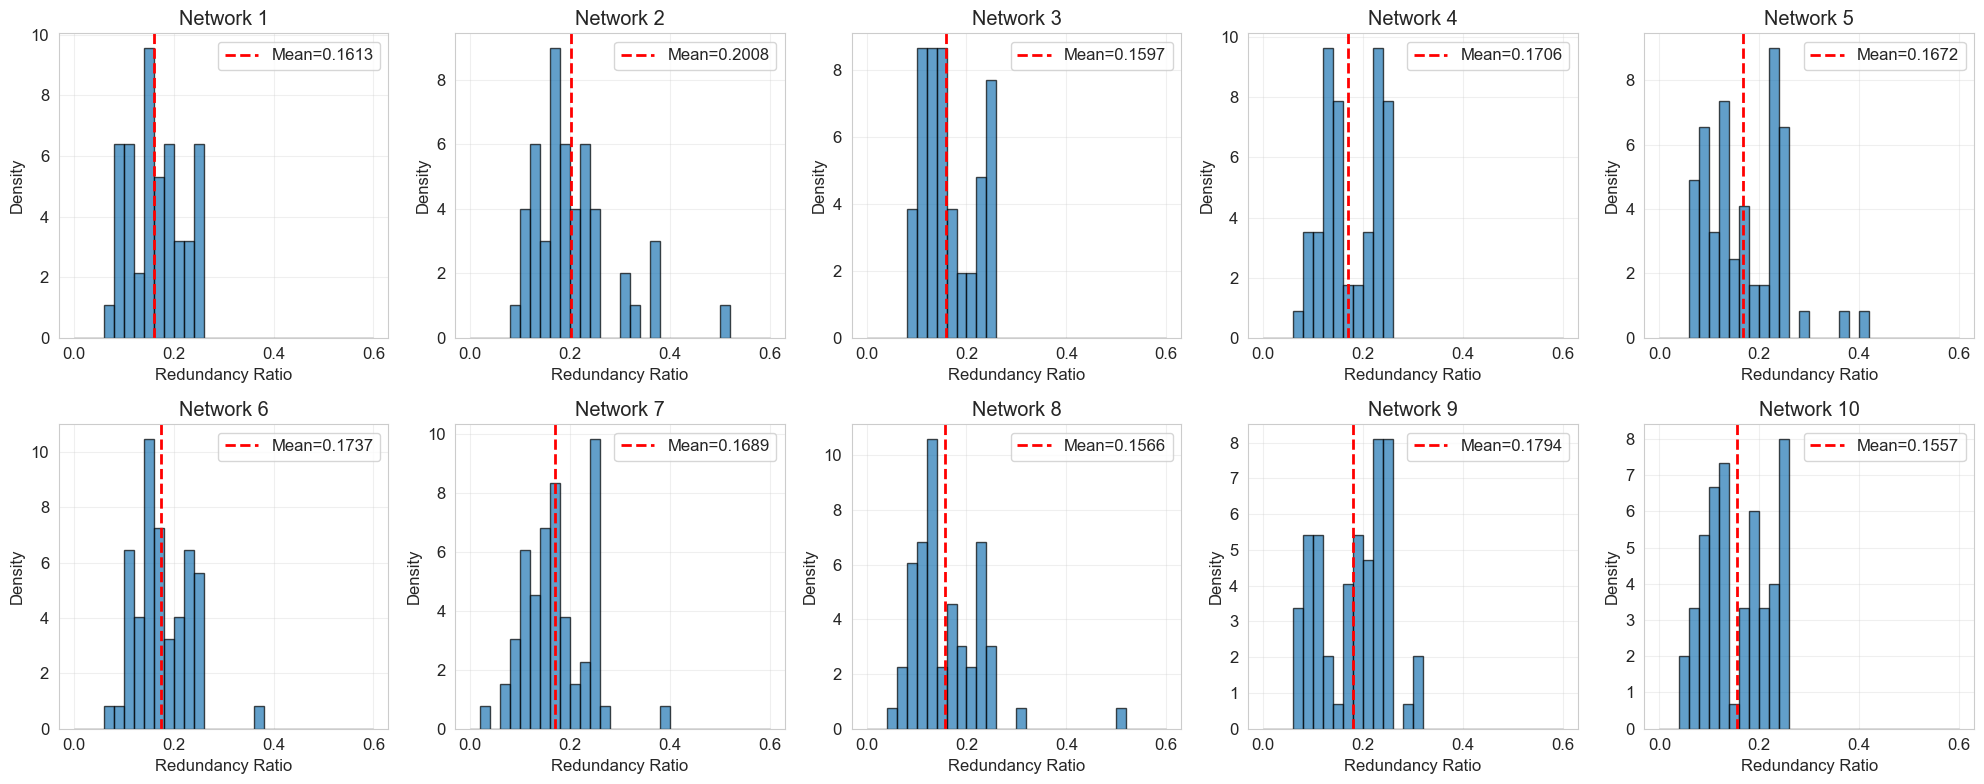


Summary of Redundancy Ratios:
Network 1: Mean RR = 0.161292
Network 2: Mean RR = 0.200847
Network 3: Mean RR = 0.159725
Network 4: Mean RR = 0.170618
Network 5: Mean RR = 0.167169
Network 6: Mean RR = 0.173700
Network 7: Mean RR = 0.168854
Network 8: Mean RR = 0.156595
Network 9: Mean RR = 0.179354
Network 10: Mean RR = 0.155719


In [4]:
# ============================================================================
# QUESTION 1: Redundancy Ratio Analysis
# ============================================================================

def compute_redundancy_ratio_for_node(G, v, debug=False):
    """
    Compute redundancy ratio for a single node v.
    
    RR_v = (1 / (|S|-1)^2) * sum_{j in N_2(v)} I(v,j)
    
    where:
    - N_1(v): neighbors of v (distance 1)
    - N_2(v): neighbors of neighbors of v
    - S = {v} ∪ N_1(v) ∪ N_2(v)
    - I(v,j): number of node-disjoint paths between v and j
    """
    try:
        # Get neighbors at distance 1
        N_1 = set(G.neighbors(v))
        
        # Get all neighbors of neighbors
        N_2 = set()
        for neighbor in N_1:
            for second_neighbor in G.neighbors(neighbor):
                # if second_neighbor != v and second_neighbor not in N_1:
                if second_neighbor != v:
                    N_2.add(second_neighbor)
        
        # If no neighbors of neighbors, redundancy ratio is 0
        if len(N_2) == 0:
            return 0.0
        
        # Compute S = {v} ∪ N_1(v) ∪ N_2(v)
        S = {v}.union(N_1).union(N_2)
        S_size = len(S)
        
        # Avoid division by zero
        if S_size <= 1:
            return 0.0
        
        # Compute sum of node-disjoint paths from v to all nodes in N_2
        total_disjoint_paths = 0
        for j in N_2:
            try:
                # Number of node-disjoint paths from v to j
                num_paths = nx.node_connectivity(G, v, j)
                total_disjoint_paths += num_paths
            except:
                total_disjoint_paths += 0
        
        # Compute redundancy ratio
        RR_v = total_disjoint_paths / ((S_size - 1) ** 2)
        if debug:
            print(f"High RR detected for node {v}: RR = {RR_v}, |S| = {S_size}, total paths = {total_disjoint_paths}")
        return RR_v
    
    except Exception as e:
        return 0.0

def compute_network_redundancy_ratio(G, debug=False):
    """
    Compute redundancy ratio for all nodes in network and return statistics.
    """
    RR_values = []
    nodes = list(G.nodes())
    
    print(f"  Computing RR for {len(nodes)} nodes...")
    for i, v in enumerate(nodes):
        if i % 100 == 0:
            print(f"    Progress: {i}/{len(nodes)} nodes")
        RR_v = compute_redundancy_ratio_for_node(G, v, debug=debug)
        RR_values.append(RR_v)
    
    return np.array(RR_values)

print("\n" + "="*80)
print("QUESTION 1: Redundancy Ratio Analysis")
print("="*80)

# Compute RR for first 10 networks
RR_results = {}
for net_id in range(1, 11):
    if net_id in networks:
        print(f"\nProcessing Network {net_id}...")
        G = networks[net_id]
        if net_id == 8:
            # Enable debug for network 8 due to known high RR nodes
            RR_values = compute_network_redundancy_ratio(G, debug=True)
        else:
            RR_values = compute_network_redundancy_ratio(G)
        avg_RR = np.mean(RR_values)
        
        RR_results[net_id] = {
            'values': RR_values,
            'mean': avg_RR,
            'std': np.std(RR_values),
            'median': np.median(RR_values),
            'min': np.min(RR_values),
            'max': np.max(RR_values)
        }
        
        print(f"  Average RR: {avg_RR:.6f}")
        print(f"  Std Dev: {RR_results[net_id]['std']:.6f}")
        print(f"  Range: [{RR_results[net_id]['min']:.6f}, {RR_results[net_id]['max']:.6f}]")

# Visualize histograms
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, net_id in enumerate(range(1, 11)):
    if net_id in RR_results:
        ax = axes[idx]
        RR_values = RR_results[net_id]['values']
        
        # Plot normalized histogram
        ax.hist(RR_values, range=(0, 0.6), bins=30, density=True, alpha=0.7, edgecolor='black')
        ax.axvline(RR_results[net_id]['mean'], color='red', linestyle='--', 
                   linewidth=2, label=f'Mean={RR_results[net_id]["mean"]:.4f}')
        ax.set_xlabel('Redundancy Ratio')
        ax.set_ylabel('Density')
        ax.set_title(f'Network {net_id}')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'./results/{file_prefix}_q1_redundancy_ratio_histograms.pdf', dpi=500, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("Summary of Redundancy Ratios:")
print("="*80)
for net_id in range(1, 11):
    if net_id in RR_results:
        print(f"Network {net_id}: Mean RR = {RR_results[net_id]['mean']:.6f}")



QUESTION 2: Pearson's Pair-wise Similarity

Computing Pearson similarity for Network 1...
  Matrix shape: (47, 47)
  Mean similarity: 0.0290
  Std similarity: 0.2220

Computing Pearson similarity for Network 10...
  Matrix shape: (75, 75)
  Mean similarity: 0.0141
  Std similarity: 0.1675


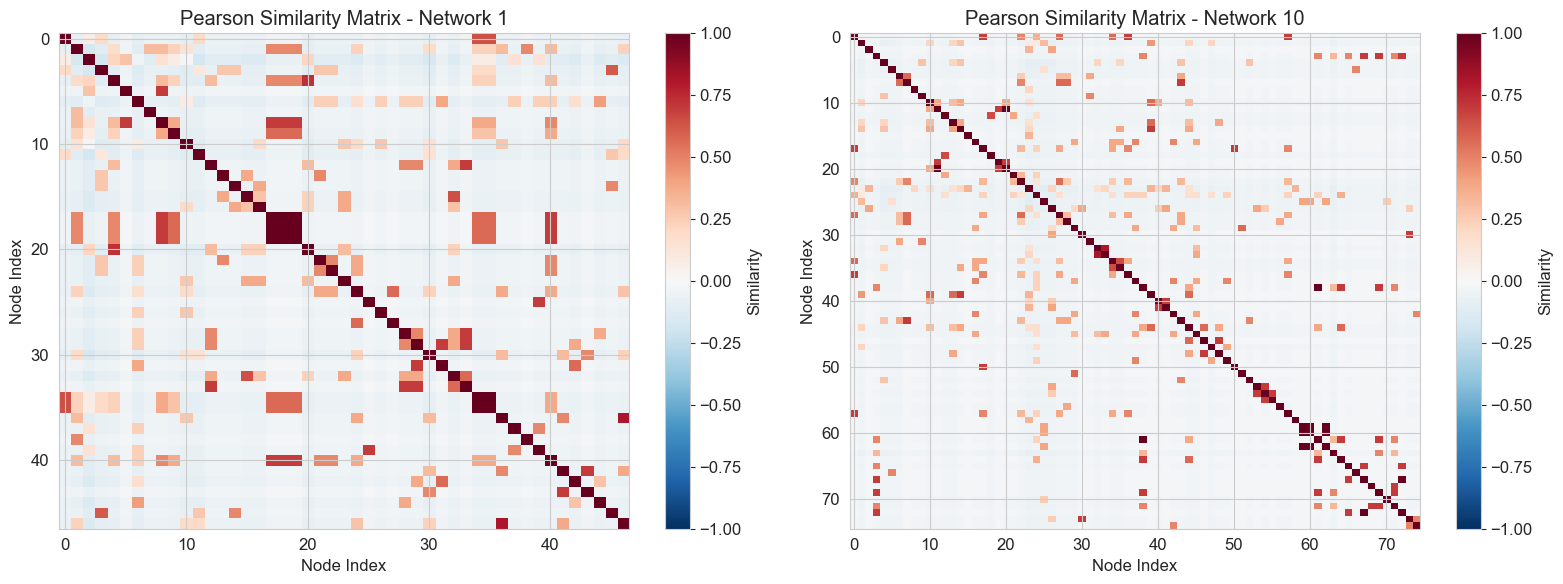

In [5]:

# ============================================================================
# QUESTION 2: Pearson's Pair-wise Similarity
# ============================================================================

def compute_pearson_similarity(G):
    """
    Compute Pearson correlation-based similarity matrix.
    For each pair of nodes (i,j), compute correlation of their adjacency patterns.
    """
    adj_matrix = nx.to_numpy_array(G)
    n = len(adj_matrix)
    
    # Initialize similarity matrix
    similarity = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i == j:
                similarity[i, j] = 1.0
            else:
                # Get adjacency vectors
                vec_i = adj_matrix[i, :]
                vec_j = adj_matrix[j, :]
                
                # Compute Pearson correlation
                mean_i = np.mean(vec_i)
                mean_j = np.mean(vec_j)
                
                numerator = np.sum((vec_i - mean_i) * (vec_j - mean_j))
                denominator = np.sqrt(np.sum((vec_i - mean_i)**2) * np.sum((vec_j - mean_j)**2))
                
                if denominator > 0:
                    similarity[i, j] = numerator / denominator
                else:
                    similarity[i, j] = 0.0
    
    return similarity

print("\n" + "="*80)
print("QUESTION 2: Pearson's Pair-wise Similarity")
print("="*80)

# Compute for networks 1 and 10
pearson_similarities = {}
for net_id in [1, 10]:
    if net_id in networks:
        print(f"\nComputing Pearson similarity for Network {net_id}...")
        G = networks[net_id]
        pearson_sim = compute_pearson_similarity(G)
        pearson_similarities[net_id] = pearson_sim
        print(f"  Matrix shape: {pearson_sim.shape}")
        print(f"  Mean similarity: {np.mean(pearson_sim):.4f}")
        print(f"  Std similarity: {np.std(pearson_sim):.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, net_id in enumerate([1, 10]):
    if net_id in pearson_similarities:
        ax = axes[idx]
        sim_matrix = pearson_similarities[net_id]
        
        im = ax.imshow(sim_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
        ax.set_title(f'Pearson Similarity Matrix - Network {net_id}')
        ax.set_xlabel('Node Index')
        ax.set_ylabel('Node Index')
        plt.colorbar(im, ax=ax, label='Similarity')

plt.tight_layout()
plt.savefig(f'./results/{file_prefix}_q2_pearson_similarity.pdf', dpi=500, bbox_inches='tight')
plt.show()


QUESTION 3: Global Similarity Matrix (Sigma) and PageRank

Computing Sigma matrix for Network 1...
  Sigma matrix shape: (47, 47)
  Mean sigma value: 0.1418
  Mean PageRank score: 6.6667
  Top 5 nodes by PR score: [ 2  6 11 10  3]

Computing Sigma matrix for Network 10...
  Sigma matrix shape: (75, 75)
  Mean sigma value: 0.0889
  Mean PageRank score: 6.6667
  Top 5 nodes by PR score: [23 25 24 26  5]


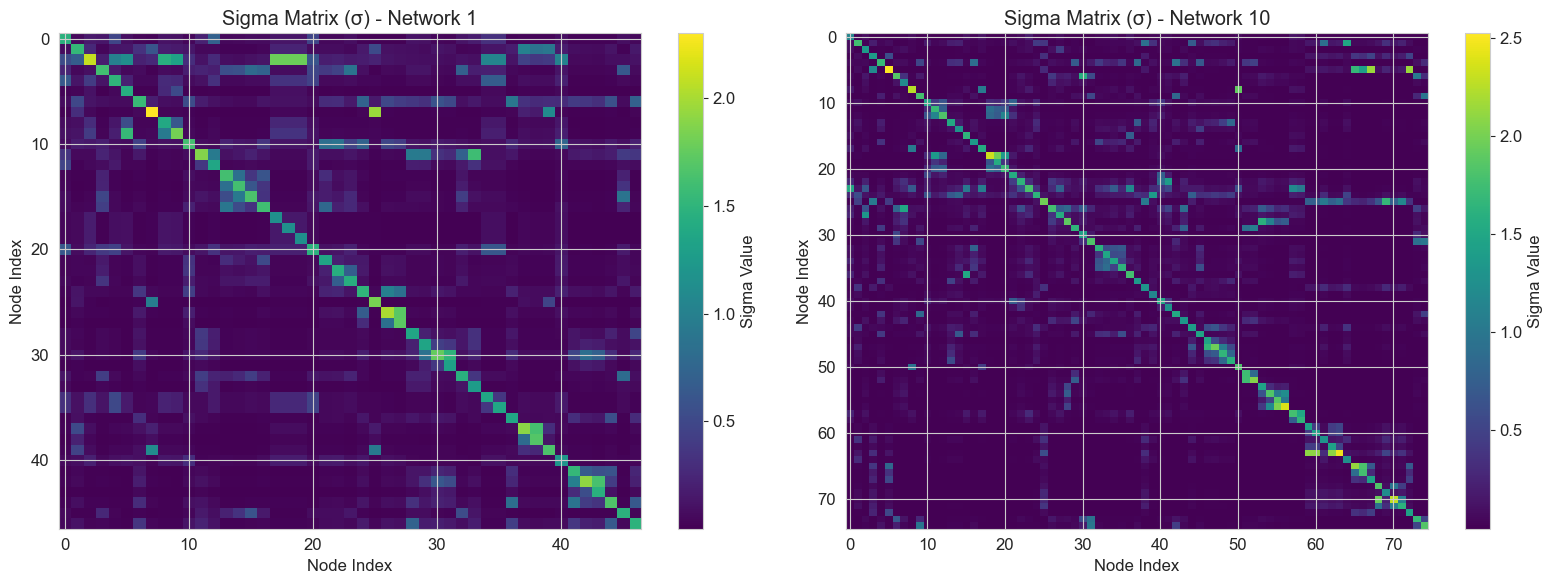

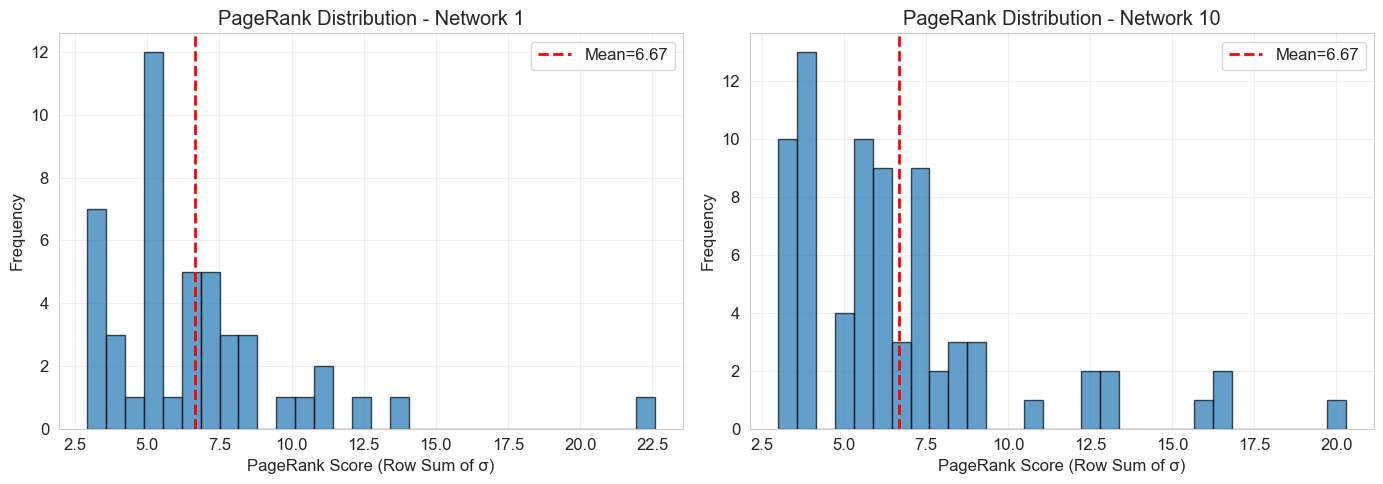

In [6]:
# ============================================================================
# QUESTION 3: Global Similarity Matrix (Sigma) and PageRank
# ============================================================================

def compute_sigma_matrix(G, alpha=0.85):
    """
    Compute global similarity matrix:
    σ = D * [D - α*A]^(-1)
    
    where:
    - D is the degree diagonal matrix
    - A is adjacency matrix
    - α is damping factor (default 0.85, similar to PageRank)
    """
    adj_matrix = nx.to_numpy_array(G)
    n = len(adj_matrix)
    
    # Compute degree matrix
    degrees = np.sum(adj_matrix, axis=1)
    D = np.diag(degrees)
    
    # Compute [D - α*A]
    M = D - alpha * adj_matrix
    
    # Check if matrix is invertible
    try:
        M_inv = np.linalg.inv(M)
    except np.linalg.LinAlgError:
        print("  Warning: Matrix not invertible, using pseudo-inverse")
        M_inv = np.linalg.pinv(M)
    
    # Compute sigma = D * M^(-1)
    sigma = D @ M_inv
    
    return sigma

print("\n" + "="*80)
print("QUESTION 3: Global Similarity Matrix (Sigma) and PageRank")
print("="*80)

# Compute for networks 1 and 10
sigma_matrices = {}
pagerank_scores = {}

for net_id in [1, 10]:
    if net_id in networks:
        print(f"\nComputing Sigma matrix for Network {net_id}...")
        G = networks[net_id]
        
        # Compute sigma matrix
        sigma = compute_sigma_matrix(G, alpha=0.85)
        sigma_matrices[net_id] = sigma
        
        # Compute PageRank-based scores (row sums of sigma)
        pr_scores = np.sum(sigma, axis=1)
        pagerank_scores[net_id] = pr_scores
        
        print(f"  Sigma matrix shape: {sigma.shape}")
        print(f"  Mean sigma value: {np.mean(sigma):.4f}")
        print(f"  Mean PageRank score: {np.mean(pr_scores):.4f}")
        print(f"  Top 5 nodes by PR score: {np.argsort(pr_scores)[-5:][::-1]}")

# Visualize sigma matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, net_id in enumerate([1, 10]):
    if net_id in sigma_matrices:
        ax = axes[idx]
        sigma = sigma_matrices[net_id]
        
        im = ax.imshow(sigma, cmap='viridis', aspect='auto')
        ax.set_title(f'Sigma Matrix (σ) - Network {net_id}')
        ax.set_xlabel('Node Index')
        ax.set_ylabel('Node Index')
        plt.colorbar(im, ax=ax, label='Sigma Value')

plt.tight_layout()
plt.savefig(f'./results/{file_prefix}_q3_sigma_matrix.pdf', dpi=500, bbox_inches='tight')
plt.show()

# Visualize PageRank distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, net_id in enumerate([1, 10]):
    if net_id in pagerank_scores:
        ax = axes[idx]
        pr_scores = pagerank_scores[net_id]
        
        ax.hist(pr_scores, bins=30, edgecolor='black', alpha=0.7)
        ax.axvline(np.mean(pr_scores), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean={np.mean(pr_scores):.2f}')
        ax.set_xlabel('PageRank Score (Row Sum of σ)')
        ax.set_ylabel('Frequency')
        ax.set_title(f'PageRank Distribution - Network {net_id}')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'./results/{file_prefix}_q3_pagerank_distribution.pdf', dpi=500, bbox_inches='tight')
plt.show()




QUESTION 4: Maximum k-Club in Network 1 (k = 1, 2, 3)

Network 1 properties:
  Nodes: 47
  Edges: 62

Searching for maximum 1-club...

Results (k=1):
  Maximum 1-club size: 3
  Is valid 1-club: True
  Actual diameter in G[club]: 1
  Nodes in club: [2, 4, 34]

1-club subgraph properties:
  Density: 1.0000
  Average degree: 2.00
  Clustering coefficient: 1.0000


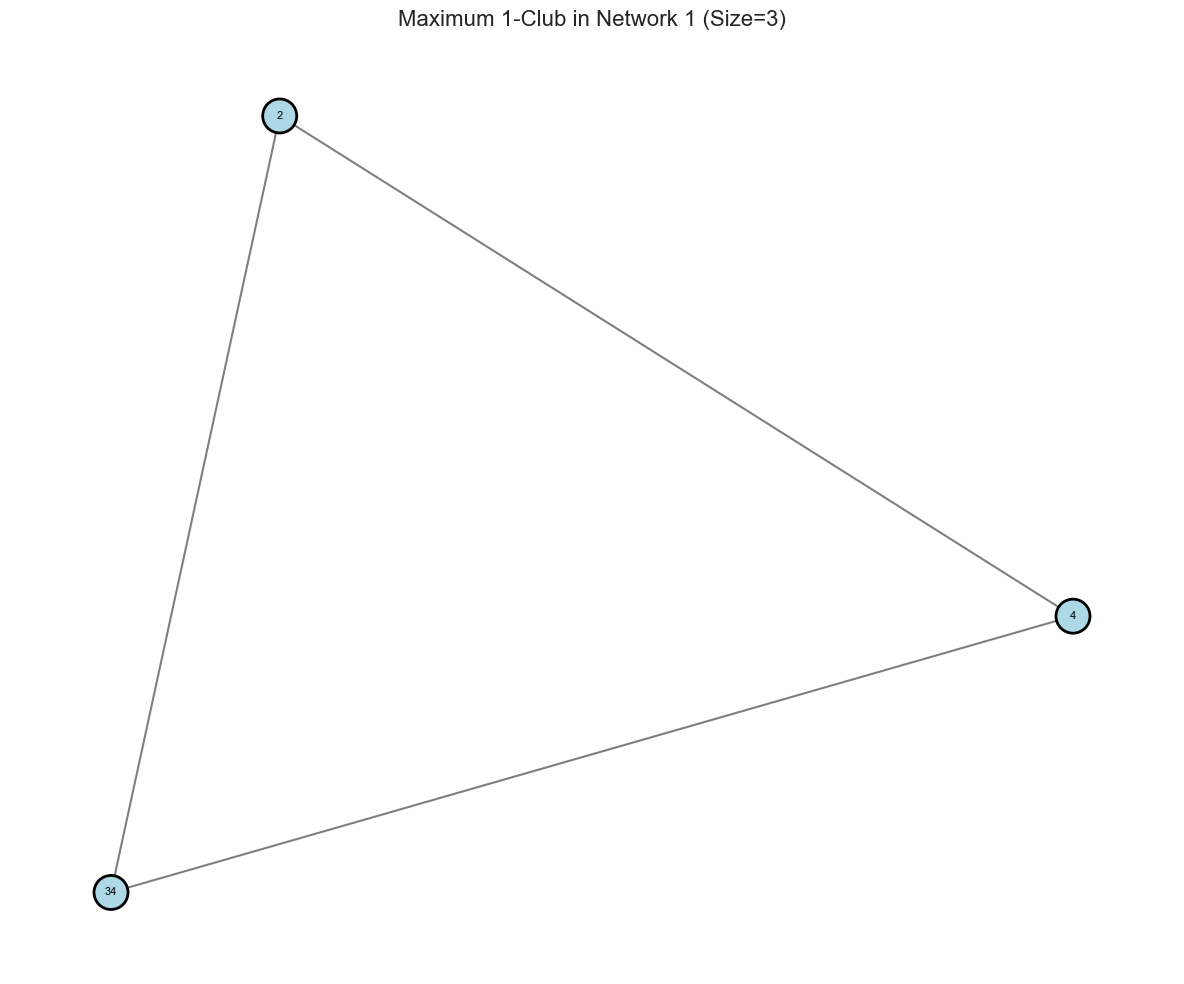


Searching for maximum 2-club...

Results (k=2):
  Maximum 2-club size: 11
  Is valid 2-club: True
  Actual diameter in G[club]: 2
  Nodes in club: [1, 2, 4, 8, 9, 17, 18, 19, 34, 35, 40]

2-club subgraph properties:
  Density: 0.2364
  Average degree: 2.36
  Clustering coefficient: 0.4303


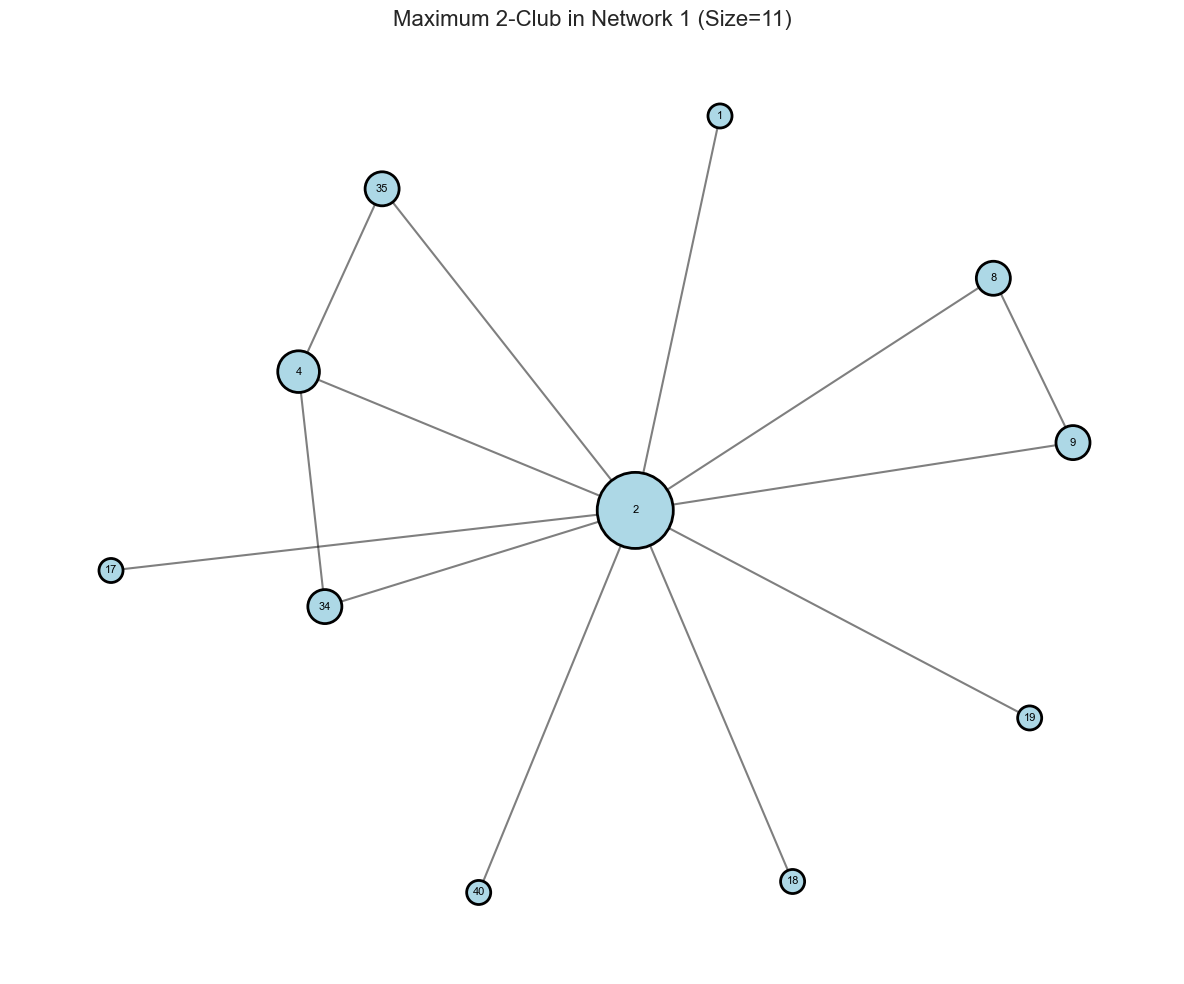


Searching for maximum 3-club...

Results (k=3):
  Maximum 3-club size: 13
  Is valid 3-club: True
  Actual diameter in G[club]: 3
  Nodes in club: [0, 1, 2, 4, 8, 9, 17, 18, 19, 20, 34, 35, 40]

3-club subgraph properties:
  Density: 0.2179
  Average degree: 2.62
  Clustering coefficient: 0.2359


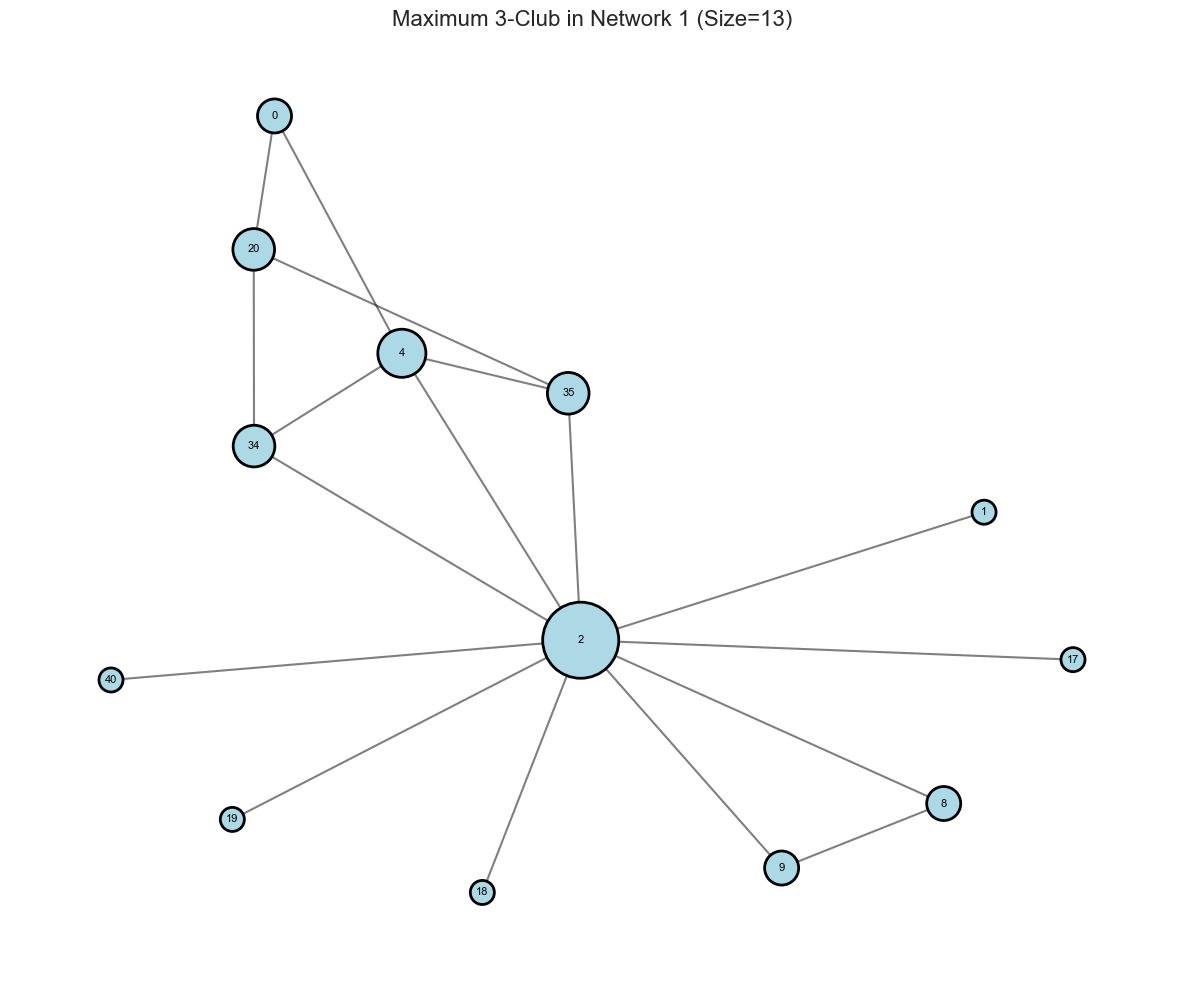


Analysis Complete!


In [7]:

def verify_k_club(G, club, k):
    """
    Verify if a set of nodes forms a k-club.
    """
    if not club:
        return False, float('inf')
    H = G.subgraph(club).copy()
    if H.number_of_nodes() == 1:
        return True, 0
    if not nx.is_connected(H):
        return False, float('inf')
    # networkx.diameter uses eccentricity; fine for moderate sizes
    try:
        d = nx.diameter(H)
    except nx.NetworkXError:
        # disconnected fallback (shouldn't happen due to check above)
        return False, float('inf')
    return d <= k, d

# --- k=1 case: maximum clique --------------------------------------------------

def maximum_1_club_as_clique(G):
    """
    A 1-club is exactly a clique. Return the largest clique (exact).
    """
    # exact enumeration; for larger graphs consider approximation
    max_clq = max(nx.find_cliques(G), key=len, default=[])
    return list(max_clq)

# --- Greedy k-club (k >= 2) ---------------------------------------------------

def find_max_k_club_greedy(G, k=2, start_pool=20):
    """
    Greedy heuristic for maximum k-club.
    - Seeds by highest degree
    - Iteratively adds nodes if the induced subgraph keeps diameter <= k
    """
    nodes = list(G.nodes())
    if not nodes:
        return []
    degrees = dict(G.degree())
    sorted_nodes = sorted(nodes, key=lambda x: degrees[x], reverse=True)

    best_club = []
    best_size = 0

    # Try multiple high-degree seeds
    for start_node in sorted_nodes[:min(start_pool, len(sorted_nodes))]:
        current_club = [start_node]

        for candidate in sorted_nodes:
            if candidate in current_club:
                continue

            test_club = current_club + [candidate]
            H = G.subgraph(test_club)

            if not nx.is_connected(H):
                continue

            # Fast reject: if k is small, use eccentricity cutoff
            # (diameter <= k <=> max eccentricity <= k)
            # This is typically faster than full diameter repeatedly.
            ecc_ok = True
            for s in test_club:
                # cutoff helps short-circuit search
                lengths = nx.single_source_shortest_path_length(H, s, cutoff=k)
                if len(lengths) < len(test_club):
                    ecc_ok = False
                    break
            if not ecc_ok:
                continue

            # Passed quick checks; accept the candidate
            current_club = test_club

        if len(current_club) > best_size:
            best_size = len(current_club)
            best_club = current_club

    return best_club

# --- Wrapper to handle k = 1, 2, 3 uniformly ----------------------------------

def compute_max_k_club(G, k, start_pool=20):
    if k == 1:
        club = maximum_1_club_as_clique(G)
    else:
        club = find_max_k_club_greedy(G, k=k, start_pool=start_pool)
    ok, diam = verify_k_club(G, club, k)
    return club, ok, diam

# --- Reporting + Visualization -------------------------------------------------

print("\n" + "="*80)
print("QUESTION 4: Maximum k-Club in Network 1 (k = 1, 2, 3)")
print("="*80)

if 1 in networks:
    G = networks[1]
    print(f"\nNetwork 1 properties:")
    print(f"  Nodes: {G.number_of_nodes()}")
    print(f"  Edges: {G.number_of_edges()}")

    for k in [1, 2, 3]:
        print(f"\nSearching for maximum {k}-club...")
        club, is_valid, diameter = compute_max_k_club(G, k=k, start_pool=30)

        # Basic stats
        H = G.subgraph(club).copy()
        dens = nx.density(H) if H.number_of_nodes() > 1 else 0.0
        avg_deg = (np.mean([d for _, d in H.degree()]) if H.number_of_nodes() > 0 else 0.0)
        clust = (nx.average_clustering(H) if H.number_of_nodes() > 1 else 0.0)

        print(f"\nResults (k={k}):")
        print(f"  Maximum {k}-club size: {len(club)}")
        print(f"  Is valid {k}-club: {is_valid}")
        print(f"  Actual diameter in G[club]: {diameter}")
        preview = sorted(club)
        if len(preview) > 20:
            preview = preview[:20]
            print(f"  Nodes in club (first 20): {preview} ...")
        else:
            print(f"  Nodes in club: {preview}")

        print(f"\n{k}-club subgraph properties:")
        print(f"  Density: {dens:.4f}")
        print(f"  Average degree: {avg_deg:.2f}")
        print(f"  Clustering coefficient: {clust:.4f}")

        # Visualization (skip if empty or single node)
        if H.number_of_nodes() >= 2:
            plt.figure(figsize=(12, 10))
            pos = nx.spring_layout(H, k=0.5, iterations=50, seed=42)
            node_sizes = [300 * (H.degree(n) if H.degree(n) > 0 else 1) for n in H.nodes()]
            nx.draw_networkx_nodes(H, pos, node_size=node_sizes, node_color='lightblue',
                                   edgecolors='black', linewidths=2)
            nx.draw_networkx_edges(H, pos, alpha=0.5, width=1.5)
            # Add labels only if not too crowded
            if H.number_of_nodes() <= 60:
                nx.draw_networkx_labels(H, pos, font_size=8)
            plt.title(f'Maximum {k}-Club in Network 1 (Size={len(club)})', fontsize=16)
            plt.axis('off')
            plt.tight_layout()
            out_path = os.path.join(f'./results', f'{file_prefix}_q4_max_{k}club.pdf')
            plt.savefig(out_path, dpi=500, bbox_inches='tight')
            plt.show()
        else:
            print(f"(Visualization skipped for k={k}: club too small.)")

else:
    print("Network 1 not found in `networks`.")

print("\n" + "="*80)
print("Analysis Complete!")
print("="*80)

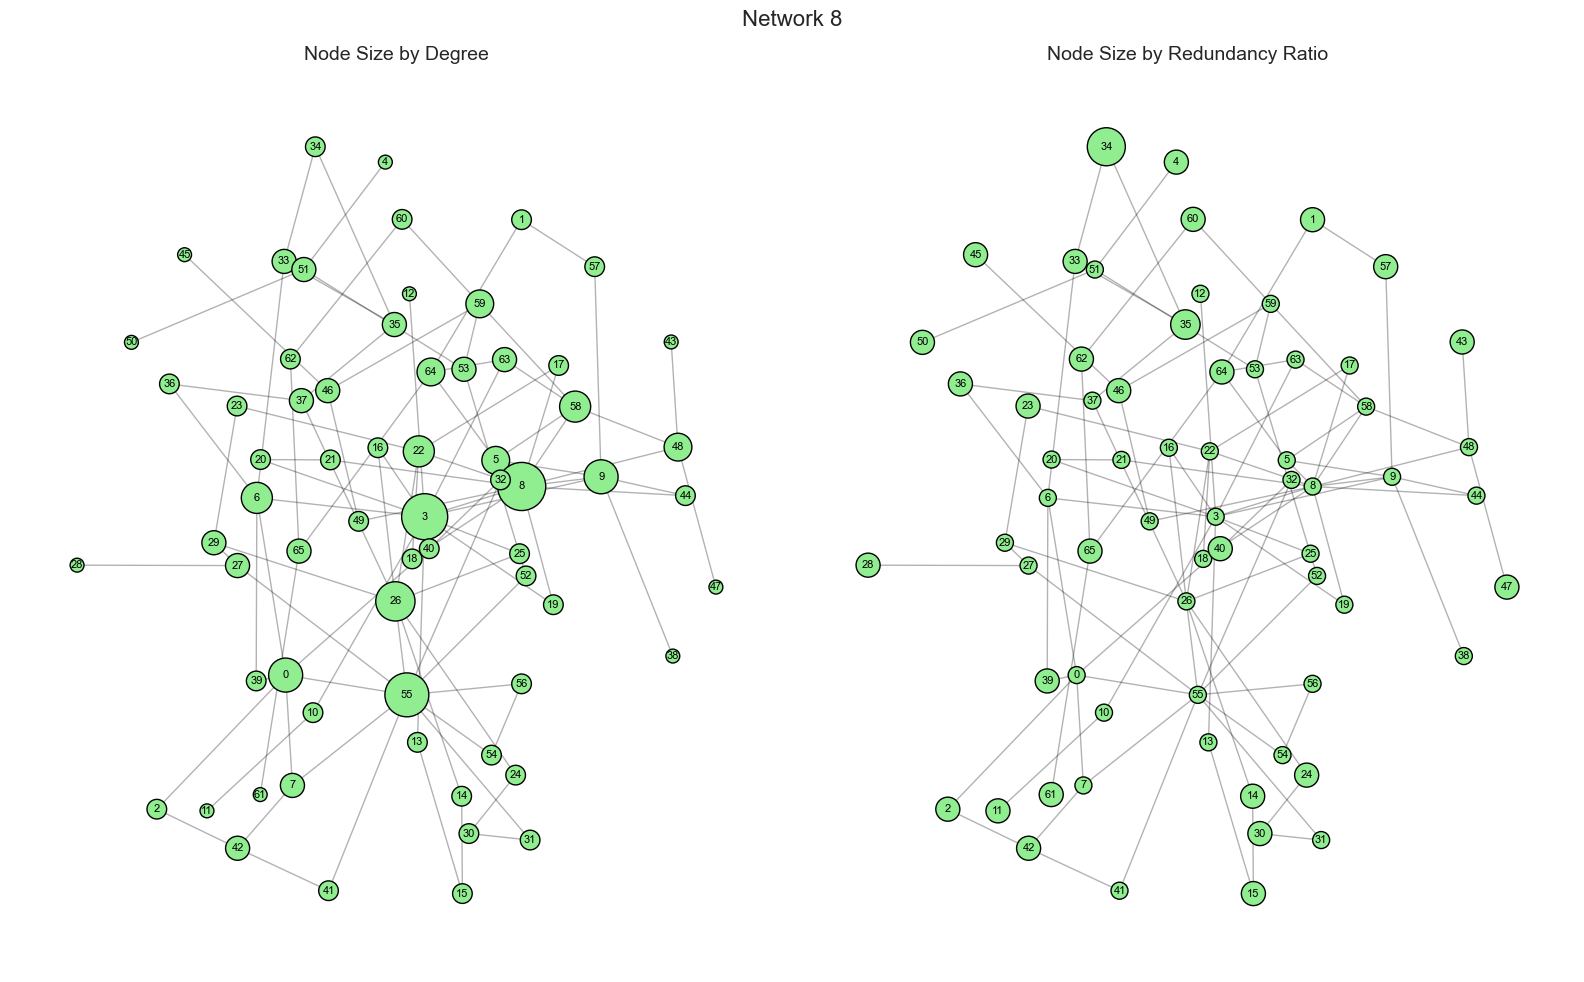

In [8]:
# visualize network
def visualize_network(G, RR_values):
    """
    Visualize the network G with node sizes based on degree and RR values.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))
    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
    node_sizes = [100 * (G.degree(n) if G.degree(n) > 0 else 1) for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightgreen',
                           edgecolors='black', linewidths=1, ax=axes[0])
    # plot nodes with size based on RR_values
    node_sizes = [1500 * round(val, 1) for val in RR_values]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightgreen',
                           edgecolors='black', linewidths=1, ax=axes[1])
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=1, ax=axes[0])
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=1, ax=axes[1])
    # Add labels only if not too crowded
    if G.number_of_nodes() <= 100:
        nx.draw_networkx_labels(G, pos, font_size=8, ax=axes[0])
        nx.draw_networkx_labels(G, pos, font_size=8, ax=axes[1])
    plt.suptitle(f'Network 8', fontsize=16)
    axes[0].set_title('Node Size by Degree', fontsize=14)
    axes[0].axis('off')
    axes[1].set_title('Node Size by Redundancy Ratio', fontsize=14)
    axes[1].axis('off')

    plt.tight_layout()
    out_path = os.path.join(f'./results', f'{file_prefix}_network_{net_id}_visualization.pdf')
    plt.savefig(out_path, dpi=500, bbox_inches='tight')
    plt.show()
    return

net_id = 8
if net_id in networks:
    G = networks[net_id]
    RR_values = RR_results[net_id]['values']
    visualize_network(G, RR_values)